## Employee Retention Dataset and Survival Analysis

Ying Ma
03/29/2019

### Data Description
Data comes from several companies and their employees who joined from 2011/01/24 to 2015/12/13. 

For each employee, their status of employment is available  as of 2015/12/13. Beside that, general info about the employees, such as avg salary, department, and yrs of experience are also available.

As said above, the goal is to find and visualize employee retention and its main drivers

In [3]:
# loading packages
from lifelines import CoxPHFitter #survival analysis library
from lifelines import KaplanMeierFitter 

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv('~/roman/Jupyter Lab/employee_retention.csv',index_col=0)

In [5]:
df.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34702 entries, 0 to 34701
Data columns (total 7 columns):
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null object
quit_date      23510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 2.1+ MB


## Pre-processing

In [7]:
# adjust data types
df.employee_id = df.employee_id.astype(int)
df.company_id = df.company_id.astype('category')
df.dept = df.dept.astype('category')

# remove non-valid data
df = df.drop(df.index[df.seniority>30])
df = df.drop(df.index[df.salary.isna()])

# adjust data type for Dates
df.join_date = pd.to_datetime(df.join_date)
df.quit_date = pd.to_datetime(df.quit_date)

# remove contractors
df = df.drop(df.index[df.dept == 'temp_contractor'])

### define churning

In [8]:
# define churning as 1 if the person already quit (have a quit date)
df["churning"] = (~df.quit_date.isnull())

### calculate alive duration

In [9]:
# fill the quit_date with the last date
df["quit_date_fill"] = df.quit_date
df['quit_date_fill'].loc[df.quit_date_fill.isnull()]=pd.to_datetime('2015/12/13')

# calculate the duration between join and quit date
df['duration'] = (df.quit_date_fill - df.join_date).dt.days

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Visualization

Text(0,0.5,'Percent Alive')

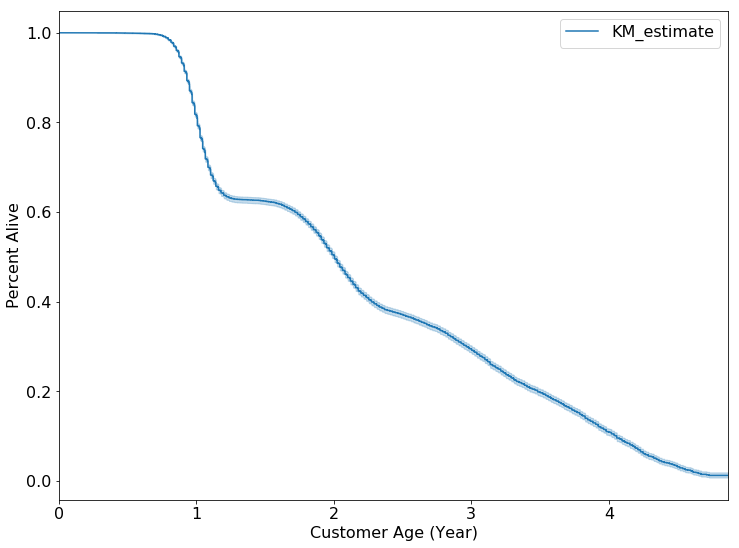

In [41]:
T = df["duration"]/365
E = df["churning"]
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(1, figsize = (12,9))

kmf.fit(T, event_observed=E)
kmf.plot(ax=ax,ci_force_lines=False,ci_show=True)
plt.legend(fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize =16)
plt.xlabel('Customer Age (Year)', fontsize = 16)
plt.ylabel('Percent Alive', fontsize = 16)


###  Segementation by salary
Using techniques mentioned above, the salary can be binned into 6 categories

In [16]:
# create bins for salary range

lss = list(range(0, 400001, 100000))

In [17]:
# derive interval list# deriv 
salary_bin_labels = [ "{} - {}".format(lss[i-1], lss[i]) for i in range(1,len(lss)) ]
print('salary bins')
print(salary_bin_labels)
salary_bins = pd.cut(df.salary, lss, right=False, labels=salary_bin_labels)


salary bins
['0 - 100000', '100000 - 200000', '200000 - 300000', '300000 - 400000']


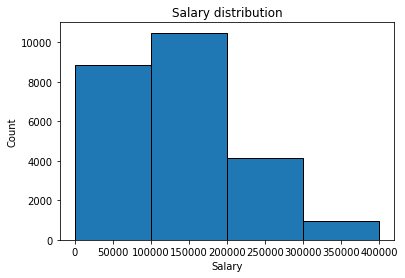

In [18]:
plt.hist(df.salary, lss, edgecolor = 'k');
plt.xlabel('Salary');
plt.ylabel('Count');
plt.title('Salary distribution');

Text(0,0.5,'Percent Alive')

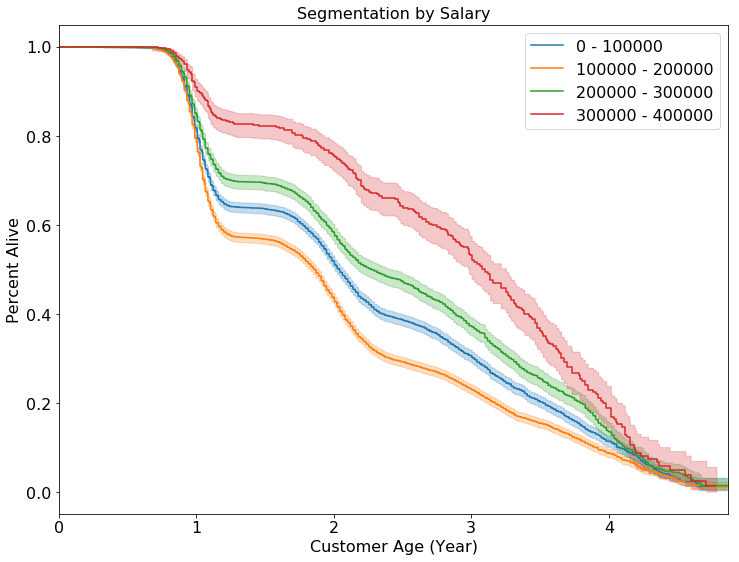

In [35]:
T = df["duration"]/365
E = df["churning"]

kmf.fit(T, event_observed=E)
fig, ax = plt.subplots(figsize=(12, 9))
# ax = plt.subplot(111)

for i in salary_bin_labels:
    dem = (salary_bins == i)
    kmf.fit(T[dem], event_observed=E[dem])
    kmf.plot(ax=ax, ci_force_lines=False)

plt.tick_params(axis='both', which='major', labelsize =16)
plt.legend(salary_bin_labels, fontsize = 16)
plt.title('Segmentation by Salary', fontsize = 16)
plt.xlabel('Customer Age (Year)', fontsize = 16)
plt.ylabel('Percent Alive', fontsize = 16)



It is obvious that the most stable group has the highest salary. The most unstable group has salary ranging from 100k-200k. 